In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import pandas as pd
import datetime as datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
#import psycopg2
from scipy.stats import ks_2samp
import scipy.stats as scats
# import visuals as vs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

import yaml

from icu_mortality_prediction import DATA_DIR


In [2]:
from icu_mortality_prediction.src.features import ptnt_demog
from icu_mortality_prediction.src.utils import data_utils

# MIMIC-III Critical Care Database

MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (both in and out of hospital).

MIMIC supports a diverse range of analytic studies spanning epidemiology, clinical decision-rule improvement, and electronic tool development. It is notable for three factors:

it is freely available to researchers worldwide
it encompasses a diverse and very large population of ICU patients
it contains high temporal resolution data including lab results, electronic documentation, and bedside monitor trends and waveforms.

Citations: 
MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available at: http://www.nature.com/articles/sdata201635

Pollard, T. J. & Johnson, A. E. W. The MIMIC-III Clinical Database http://dx.doi.org/10.13026/C2XW26 (2016).



# IMPORTING DATA
The mimic III database was downloaded and reconstructed locally using posgresql. The database was managed graphically using Portico. 
A query was run on the mimic III database to generate demographic data and data concerning hospital and ICU stays for patients diagnosed with sepsis according to the Angus criteria (Angus et al, 2001. Epidemiology of severe sepsis in the United States; http://www.ncbi.nlm.nih.gov/pubmed/11445675 )

The query was exported from Porticoto the file PTNT_DEMOG_FIRST24.csv. The data was read into a pandas dataframe lab_events.

## IMPORTING DATA

In [53]:
# patient demographic data includes diagnoses and icd9 codes for each patient and each icustay
demographics_filename = 'PTNT_DEMOG_FIRST24.csv'
demographics_filepath = os.path.join(DATA_DIR, 'interim',demographics_filename)
ptnt_demog_data_df = pd.read_csv(demographics_filepath, index_col=0)
# removes duplicate rows

demographic_features_filename = 'Ptnt_Demog_Features.csv'
demographic_features_filepath = os.path.join(DATA_DIR, 
                                             'processed', 
                                             'features',
                                             demographic_features_filename)

In [4]:
ptnt_demog_data_df.head()

,hadm_id,subject_id,first_careunit,gender,marital_status,ethnicity,insurance,admission_type,admittime,dischtime,intime,outtime,deathtime,dob,hospital_expire_flag,icd9_code,icd9_code.1,short_title,seq_num
icustay_id,,,,,,,,,,,,,,,,,,,
211552,145834,3,MICU,M,MARRIED,WHITE,Medicare,EMERGENCY,2101-10-20 19:08:00,2101-10-31 13:58:00,2101-10-20 19:10:11,2101-10-26 20:43:09,NaN,2025-04-11 00:00:00,0,0389,0389,Septicemia NOS,1
211552,145834,3,MICU,M,MARRIED,WHITE,Medicare,EMERGENCY,2101-10-20 19:08:00,2101-10-31 13:58:00,2101-10-20 19:10:11,2101-10-26 20:43:09,NaN,2025-04-11 00:00:00,0,5849,5849,Acute kidney failure NOS,3
211552,145834,3,MICU,M,MARRIED,WHITE,Medicare,EMERGENCY,2101-10-20 19:08:00,2101-10-31 13:58:00,2101-10-20 19:10:11,2101-10-26 20:43:09,NaN,2025-04-11 00:00:00,0,4275,4275,Cardiac arrest,4
211552,145834,3,MICU,M,MARRIED,WHITE,Medicare,EMERGENCY,2101-10-20 19:08:00,2101-10-31 13:58:00,2101-10-20 19:10:11,2101-10-26 20:43:09,NaN,2025-04-11 00:00:00,0,41071,41071,"Subendo infarct, initial",5
211552,145834,3,MICU,M,MARRIED,WHITE,Medicare,EMERGENCY,2101-10-20 19:08:00,2101-10-31 13:58:00,2101-10-20 19:10:11,2101-10-26 20:43:09,NaN,2025-04-11 00:00:00,0,4280,4280,CHF NOS,6


In [5]:
ptnt_demog_data_df[~ptnt_demog_data_df.index.duplicated(keep='first')].shape

(44152, 19)

In [6]:
# DEBUG CODE: TAKE ONLY SAMPLE OF DF
ptnt_demog_data_df = ptnt_demog_data_df.head(10000)

In [7]:
ptnt_demog_data2_df = ptnt_demog_data_df[~ptnt_demog_data_df.index.duplicated(keep='first')].copy()
print("imported")

imported


In [8]:
ptnt_demog_data2_df.head()

,hadm_id,subject_id,first_careunit,gender,marital_status,ethnicity,insurance,admission_type,admittime,dischtime,intime,outtime,deathtime,dob,hospital_expire_flag,icd9_code,icd9_code.1,short_title,seq_num
icustay_id,,,,,,,,,,,,,,,,,,,
211552,145834,3,MICU,M,MARRIED,WHITE,Medicare,EMERGENCY,2101-10-20 19:08:00,2101-10-31 13:58:00,2101-10-20 19:10:11,2101-10-26 20:43:09,NaN,2025-04-11 00:00:00,0,0389,0389,Septicemia NOS,1
294638,185777,4,MICU,F,SINGLE,WHITE,Private,EMERGENCY,2191-03-16 00:28:00,2191-03-23 18:41:00,2191-03-16 00:29:31,2191-03-17 16:46:31,NaN,2143-05-12 00:00:00,0,2763,2763,Alkalosis,4
228232,107064,6,SICU,F,MARRIED,WHITE,Medicare,ELECTIVE,2175-05-30 07:15:00,2175-06-15 16:00:00,2175-05-30 21:30:54,2175-06-03 13:39:54,NaN,2109-06-21 00:00:00,0,40391,40391,Hyp kid NOS w cr kid V,1
220597,150750,9,MICU,M,NaN,UNKNOWN/NOT SPECIFIED,Medicaid,EMERGENCY,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-09 13:07:02,2149-11-14 20:52:14,2149-11-14 10:15:00,2108-01-26 00:00:00,1,431,431,Intracerebral hemorrhage,1
232669,112213,12,SICU,M,MARRIED,WHITE,Medicare,ELECTIVE,2104-08-07 10:15:00,2104-08-20 02:57:00,2104-08-08 02:08:17,2104-08-15 17:22:25,2104-08-20 02:57:00,2032-03-24 00:00:00,1,E8782,E8782,Abn react-anastom/graft,9


In [9]:
ptnt_demog_data2_df.shape

(1618, 19)

In [10]:
ptnt_demog_data2_df = ptnt_demog.calculate_age_icu_and_hospital_stay_durations(ptnt_demog_data2_df)

Calculating ages, duration of stays


In [11]:
ptnt_demog_data2_df.columns

Index(['hadm_id', 'subject_id', 'first_careunit', 'gender', 'marital_status',
       'ethnicity', 'insurance', 'admission_type', 'admittime', 'dischtime',
       'intime', 'outtime', 'deathtime', 'dob', 'hospital_expire_flag',
       'icd9_code', 'icd9_code.1', 'short_title', 'seq_num', 'age',
       'icu_stay_duration', 'hosp_stay_duration'],
      dtype='object')

In [12]:
ptnt_demog_data2_df = ptnt_demog.reconfigure_patient_demographics_columns(ptnt_demog_data2_df)

Reconfiguring columns


In [13]:
ptnt_demog_data2_df = ptnt_demog.truncate_age_values(ptnt_demog_data2_df)

In [14]:
ptnt_demog_data2_df['age'].describe()

count    1562.000000
mean       63.442382
std        16.348764
min        18.000000
25%        53.000000
50%        67.000000
75%        77.000000
max        89.000000
Name: age, dtype: float64

In [15]:
ptnt_demog_data2_df.columns

Index(['hadm_id', 'age', 'icu_stay_duration', 'hosp_stay_duration',
       'subject_id', 'first_careunit', 'gender', 'marital_status', 'ethnicity',
       'insurance', 'admission_type', 'deathtime', 'hospital_expire_flag'],
      dtype='object')

In [16]:
ptnt_demog_data2_df.head()

,hadm_id,age,icu_stay_duration,hosp_stay_duration,subject_id,first_careunit,gender,marital_status,ethnicity,insurance,admission_type,deathtime,hospital_expire_flag
icustay_id,,,,,,,,,,,,,
211552,145834,76.0,146.0,259.0,3,MICU,M,MARRIED,WHITE,Medicare,EMERGENCY,NaN,0
294638,185777,48.0,41.0,187.0,4,MICU,F,SINGLE,WHITE,Private,EMERGENCY,NaN,0
228232,107064,66.0,89.0,393.0,6,SICU,F,MARRIED,WHITE,Medicare,ELECTIVE,NaN,0
220597,150750,41.0,128.0,118.0,9,MICU,M,NaN,UNKNOWN/NOT SPECIFIED,Medicaid,EMERGENCY,2149-11-14 10:15:00,1
232669,112213,72.0,184.0,305.0,12,SICU,M,MARRIED,WHITE,Medicare,ELECTIVE,2104-08-20 02:57:00,1


In [17]:
diagnoses_bm, diagnoses = ptnt_demog.create_diagnoses_defs(ptnt_demog_data_df)

# #phenotypes = add_hcup_ccs_2015_groups(diagnoses, yaml.load(open(args.phenotype_definitions, 'r')))
# print("creating diagnoses definitions")
# definitions_path = os.path.join(DATA_DIR, 'external/hcup_ccs_2015_definitions.yaml')
# definitions = yaml.load(open(definitions_path, 'r'), Loader=yaml.FullLoader)

# diagnoses = ptnt_demog_data_df[['hadm_id', 'icd9_code', 'short_title']].copy()

# # create mapping of hcup_ccs_2015_definitions to diagnoses icd9 codes
# def_map = {}
# for dx in definitions:
#     for code in definitions[dx]['codes']:
#         def_map[code] = (dx, definitions[dx]['use_in_benchmark'])

        

creating diagnoses definitions
creating diagnoses definitions
map created


In [18]:
diagnoses2 = ptnt_demog.create_diagnoses_df(ptnt_demog_data2_df, diagnoses_bm, diagnoses)

In [47]:
diagnoses2.index.name = 'icustay_id'

In [48]:
diagnoses2.head()

,Septicemia (except in labor),Diabetes mellitus without complication,Diabetes mellitus with complications,Disorders of lipid metabolism,Fluid and electrolyte disorders,Essential hypertension,Hypertension with complications and secondary hypertension,Acute myocardial infarction,Coronary atherosclerosis and other heart disease,Conduction disorders,...,Pleurisy; pneumothorax; pulmonary collapse,Respiratory failure; insufficiency; arrest (adult),Other lower respiratory disease,Other upper respiratory disease,Other liver diseases,Gastrointestinal hemorrhage,Acute and unspecified renal failure,Chronic kidney disease,Complications of surgical procedures or medical care,Shock
icustay_id,,,,,,,,,,,,,,,,,,,,,
211552,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
294638,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
228232,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
220597,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
232669,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [20]:
# ptnt_demog_data2_df.drop(['subject_id', 'deathtime', 'hadm_id'], inplace = True, axis = 1)
cols = list(ptnt_demog_data2_df.columns)
cols.insert(0, cols.pop(cols.index('hospital_expire_flag')))
ptnt_demog_data2_df = ptnt_demog_data2_df[cols]


In [21]:
ptnt_demog_data2_df.head()

,hospital_expire_flag,hadm_id,age,icu_stay_duration,hosp_stay_duration,subject_id,first_careunit,gender,marital_status,ethnicity,insurance,admission_type,deathtime
icustay_id,,,,,,,,,,,,,
211552,0,145834,76.0,146.0,259.0,3,MICU,M,MARRIED,WHITE,Medicare,EMERGENCY,NaN
294638,0,185777,48.0,41.0,187.0,4,MICU,F,SINGLE,WHITE,Private,EMERGENCY,NaN
228232,0,107064,66.0,89.0,393.0,6,SICU,F,MARRIED,WHITE,Medicare,ELECTIVE,NaN
220597,1,150750,41.0,128.0,118.0,9,MICU,M,NaN,UNKNOWN/NOT SPECIFIED,Medicaid,EMERGENCY,2149-11-14 10:15:00
232669,1,112213,72.0,184.0,305.0,12,SICU,M,MARRIED,WHITE,Medicare,ELECTIVE,2104-08-20 02:57:00


In [22]:
ptnt_demog_data2_df.drop([
                            'hadm_id',
                            'subject_id', 
                            'deathtime'
                         
                         ],
                         axis=1, 
                         inplace = True)

In [23]:
ptnt_demog_data2_df.columns

Index(['hospital_expire_flag', 'age', 'icu_stay_duration',
       'hosp_stay_duration', 'first_careunit', 'gender', 'marital_status',
       'ethnicity', 'insurance', 'admission_type'],
      dtype='object')

In [24]:
demog_select_features_df = ptnt_demog_data2_df[['hospital_expire_flag', 
                                                'icu_stay_duration', 
                                                'age', 
                                                'first_careunit', 
                                                'admission_type']]

## DISPLAY DESCRIPTIVE STATS

In [25]:
display(ptnt_demog_data2_df['icu_stay_duration'].dropna().describe())
display(ptnt_demog_data2_df['hosp_stay_duration'].dropna().describe())
display(ptnt_demog_data2_df[ptnt_demog_data2_df['icu_stay_duration'] <= 0])
display(ptnt_demog_data2_df[ptnt_demog_data2_df['hosp_stay_duration'] <=0])
icu_stay_low = list(ptnt_demog_data2_df[ptnt_demog_data2_df['icu_stay_duration'] <=0]['icu_stay_duration'].unique())
age_replace_vals = list(ptnt_demog_data2_df[ptnt_demog_data2_df['age'] > 110]['age'].unique())

#ptnt_demog2.loc[:,'subject_id'] = ptnt_demog2.index
#ptnt_demog2.index = ptnt_demog2.icustay_id
#ptnt_demog2.drop('icustay_id', axis = 1, inplace = True)
#ptnt_demog2.head()

count    1618.000000
mean      128.234240
std       178.083007
min        25.000000
25%        43.000000
50%        70.000000
75%       129.000000
max      1948.000000
Name: icu_stay_duration, dtype: float64

count    1618.000000
mean      313.290482
std       319.845109
min         9.000000
25%       122.000000
50%       200.500000
75%       379.750000
max      2583.000000
Name: hosp_stay_duration, dtype: float64

,hospital_expire_flag,age,icu_stay_duration,hosp_stay_duration,first_careunit,gender,marital_status,ethnicity,insurance,admission_type
icustay_id,,,,,,,,,,


,hospital_expire_flag,age,icu_stay_duration,hosp_stay_duration,first_careunit,gender,marital_status,ethnicity,insurance,admission_type
icustay_id,,,,,,,,,,


Date and time data imported in string format is converted to pandas.datetime objects

In [26]:
columns_by_data_type_dict = data_utils.group_column_names_by_data_type(ptnt_demog_data2_df)

In [27]:
columns_by_data_type_dict

{'float64_cols': ['age', 'icu_stay_duration', 'hosp_stay_duration'],
 'categorical_cols': ['first_careunit',
  'gender',
  'marital_status',
  'ethnicity',
  'insurance',
  'admission_type'],
 'bool_cols': [],
 'int64_cols': ['hospital_expire_flag'],
 'datetime64[ns]': []}

In [28]:
print("Calling continuous to categorical conversion")
ptnt_demog_data2_df = data_utils.continuous_to_categorical(ptnt_demog_data2_df, columns_by_data_type_dict)
#print(ptnt_demog_data.head())

Calling continuous to categorical conversion
               age  icu_stay_duration  hosp_stay_duration
count  1562.000000        1562.000000         1562.000000
mean     63.442382         128.954545          315.981434
std      16.348764         180.134927          323.436033
min      18.000000          25.000000            9.000000
25%      53.000000          43.000000          121.000000
50%      67.000000          70.500000          201.000000
75%      77.000000         129.750000          381.750000
max      89.000000        1948.000000         2583.000000


In [29]:
ptnt_demog_data2_df.head()

,hospital_expire_flag,age,icu_stay_duration,hosp_stay_duration,first_careunit,gender,marital_status,ethnicity,insurance,admission_type
icustay_id,,,,,,,,,,
211552,0,Q2,Q3,Q2,MICU,M,MARRIED,WHITE,Medicare,EMERGENCY
294638,0,Q0,Q0,Q1,MICU,F,SINGLE,WHITE,Private,EMERGENCY
228232,0,Q1,Q2,Q3,SICU,F,MARRIED,WHITE,Medicare,ELECTIVE
220597,1,Q0,Q2,Q0,MICU,M,NaN,UNKNOWN/NOT SPECIFIED,Medicaid,EMERGENCY
232669,1,Q2,Q3,Q2,SICU,M,MARRIED,WHITE,Medicare,ELECTIVE


In [30]:
columns_by_data_type_dict = data_utils.group_column_names_by_data_type(ptnt_demog_data2_df)

In [31]:
columns_by_data_type_dict

{'float64_cols': [],
 'categorical_cols': ['age',
  'icu_stay_duration',
  'hosp_stay_duration',
  'first_careunit',
  'gender',
  'marital_status',
  'ethnicity',
  'insurance',
  'admission_type'],
 'bool_cols': [],
 'int64_cols': ['hospital_expire_flag'],
 'datetime64[ns]': []}

In [32]:
ptnt_demog_data2_df.head()

,hospital_expire_flag,age,icu_stay_duration,hosp_stay_duration,first_careunit,gender,marital_status,ethnicity,insurance,admission_type
icustay_id,,,,,,,,,,
211552,0,Q2,Q3,Q2,MICU,M,MARRIED,WHITE,Medicare,EMERGENCY
294638,0,Q0,Q0,Q1,MICU,F,SINGLE,WHITE,Private,EMERGENCY
228232,0,Q1,Q2,Q3,SICU,F,MARRIED,WHITE,Medicare,ELECTIVE
220597,1,Q0,Q2,Q0,MICU,M,NaN,UNKNOWN/NOT SPECIFIED,Medicaid,EMERGENCY
232669,1,Q2,Q3,Q2,SICU,M,MARRIED,WHITE,Medicare,ELECTIVE


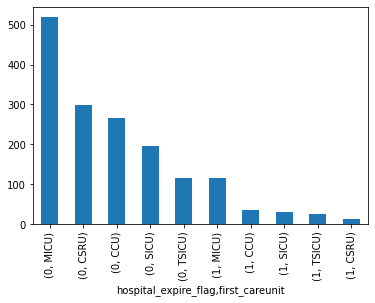

In [59]:
ptnt_demog_data2_df.groupby('hospital_expire_flag')['first_careunit'].value_counts().plot.bar(stacked = True)

In [ ]:
# # NEED TO DO SOME OVERVIEW OF DATA INCLUDING DISTRIBUTIONS, SUMMARY STATISTICS ETC
# # SINCE WE HAVE SO MUCH DATA, WE ARE JUMPING AHEAD..... IN TIME!! 
# # AND SELECTING FEATURES THAT WERE USED IN THE FINAL CLASSIFICATION


# pd.DataFrame(demog_select_features_df.groupby('hospital_expire_flag').first_careunit.value_counts()).plot.bar(stacked = True)

# icu_admits_df = pd.DataFrame(demog_select_features_df['first_careunit'].value_counts()/demog_select_features_df.shape[0])
# icu_admits_df.index

# icu_mortality_rates_df = pd.DataFrame(demog_select_features_df.groupby('first_careunit').hospital_expire_flag.sum()/ \
# demog_select_features_df.groupby('first_careunit').hospital_expire_flag.count())
# icu_admits_df.merge(icu_mortality_rates_df, left_index = True, right_index = True, 
#                        how = 'left', sort = True)

# demog_select_features_df[demog_select_features_df['first_careunit'] == 'MICU']['first_careunit'].count()



# admission_types_df = pd.DataFrame(demog_select_features_df['admission_type'].value_counts()/demog_select_features_df.shape[0])

# admission_type_mortality_rates_df = pd.DataFrame(demog_select_features_df.groupby('admission_type').hospital_expire_flag.sum()/ \
# demog_select_features_df.groupby('admission_type').hospital_expire_flag.count())

# admission_types_df.merge(admission_type_mortality_rates_df, left_index = True, right_index = True, 
#                        how = 'left', sort = True)
# '''
# earlier versions included these factors but the  process has been iterative so we 
# pre-selected relevant features above
# diagnoses2['GCS Total_15', 'GCS Total_3', 'GCS Total_6', 'GCS Total_4', 
#                           'Respiratory Failure','Shock', 'Septicemia (except in labor)', 'Acute and unspecified renal failure','Other liver diseases',
#                          'Fluid and electrolyte disorders',
#                           'Pneumonia (except that caused by tuberculosis or sexually transmitted disease)',
#                             'Acute cerebrovascular disease']
# '''

### One-Hot Encode Categorical Features

In [49]:
categorical_cols = columns_by_data_type_dict['categorical_cols']
one_hot_encoded_ptnt_demog_data_df = data_utils.one_hot_encode_categorical_features(
                                ptnt_demog_data2_df, 
                                columns_by_data_type_dict['categorical_cols']
)

In [51]:
ptnt_demog_data_and_diagnoses_df = one_hot_encoded_ptnt_demog_data_df.merge(
                        diagnoses2, 
                        left_index = True, 
                        right_index = True, 
                        how = 'left', 
                        sort = True
)

In [81]:
#diags.pop(diags.index('Diabetes mellitus without complication'))
diags = [
 'hospital_expire_flag',
 'Acute cerebrovascular disease',
 'Other liver diseases',
 'Acute and unspecified renal failure',
 'Fluid and electrolyte disorders',
 'Septicemia (except in labor)',
 'Pneumonia (except that caused by tuberculosis or sexually transmitted disease)',
 'Respiratory failure; insufficiency; arrest (adult)',
 'Shock'
 ]



diags_df = ptnt_demog_data_and_diagnoses_df[diags]
#diags_df.head()


In [74]:
expired_diag_series = diags_df[diags_df.columns[1:]][diags_df['hospital_expire_flag']==1].sum()
expired_diag_series.name = 'expired'

survived_diag_series = diags_df[diags_df.columns[1:]][diags_df['hospital_expire_flag']==0].sum()
survived_diag_series.name = 'survived'

diagnoses_by_survival_pd = pd.concat(
    [
        expired_diag_series,
        survived_diag_series
    ], 
    axis=1
)

diagnoses_by_survival_pd.plot.bar(
        label= 'Survival', 
        stacked=True, 
        figsize=(13,6)
)

In [54]:
ptnt_demog_data_and_diagnoses_df.to_csv(demographic_features_filepath)



In [57]:
pd.read_csv(demographic_features_filepath, index_col = 'icustay_id').head()

,hospital_expire_flag,age_Q0,age_Q1,age_Q2,age_Q3,icu_stay_duration_Q0,icu_stay_duration_Q1,icu_stay_duration_Q2,icu_stay_duration_Q3,hosp_stay_duration_Q0,...,Pleurisy; pneumothorax; pulmonary collapse,Respiratory failure; insufficiency; arrest (adult),Other lower respiratory disease,Other upper respiratory disease,Other liver diseases,Gastrointestinal hemorrhage,Acute and unspecified renal failure,Chronic kidney disease,Complications of surgical procedures or medical care,Shock
icustay_id,,,,,,,,,,,,,,,,,,,,,
200066,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
200085,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,1,0,0,0
200168,0,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
200184,0,0,1,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
200312,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
